# Setup:

In [1]:
import cv2, os, fnmatch
import pandas as pd
import numpy as np, math
import tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sn
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from scipy.interpolate import make_interp_spline

In [2]:
WORKING_DIR = os.path.join(os.getcwd(),"CreatedDataset")
TRAIN_DIR = os.path.join(WORKING_DIR, "train")

# Classification Training:

In [3]:
def change_model(model, new_input_shape=(None, 40, 40, 3),custom_objects=None):
    
    # replace input shape of first layer
    config = model.layers[0].get_config()
    config['batch_input_shape']=new_input_shape
    model.layers[0]=model.layers[0].from_config(config)

    # rebuild model architecture by exporting and importing via json
    new_model = tf.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
        except:
            print(f"Could not transfer weights for layer %s" %(layer.name))
            
    return new_model

In [4]:
WIDTH = 64
HEIGHT = 64
BATCH_SIZE = 20

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')

Found 5513 images belonging to 2 classes.


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False)

2022-06-25 12:18:47.206748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
CLASSES = 2
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
m = Model(inputs=base_model.input, outputs=predictions)
model = change_model(m, new_input_shape=[None] + [64,64,3])
for layer in base_model.layers:
  layer.trainable = False # Set this to True if you want to re-train the entire network.
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [7]:
EPOCHS = 15
BATCH_SIZE = 15
STEPS_PER_EPOCH = 6
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR,'model')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH)
  
model.save(MODEL_FILE)

Epoch 1/15
6/6 [==============================] - 20s 1s/step - loss: 0.9668 - accuracy: 0.8500
Epoch 2/15
6/6 [==============================] - 6s 976ms/step - loss: 0.0934 - accuracy: 0.9917
Epoch 3/15
6/6 [==============================] - 6s 966ms/step - loss: 0.1598 - accuracy: 0.9750
Epoch 4/15
6/6 [==============================] - 6s 967ms/step - loss: 0.1409 - accuracy: 0.9583
Epoch 5/15
6/6 [==============================] - 6s 1s/step - loss: 0.2012 - accuracy: 0.9667
Epoch 6/15
6/6 [==============================] - 6s 956ms/step - loss: 0.0513 - accuracy: 0.9917
Epoch 7/15
6/6 [==============================] - 6s 964ms/step - loss: 0.1964 - accuracy: 0.9583
Epoch 8/15
6/6 [==============================] - 6s 1s/step - loss: 0.2263 - accuracy: 0.9750
Epoch 9/15
6/6 [==============================] - 7s 1s/step - loss: 0.3869 - accuracy: 0.9583
Epoch 10/15
6/6 [==============================] - 6s 927ms/step - loss: 0.3142 - accuracy: 0.9833
Epoch 11/15
6/6 [=============

INFO:tensorflow:Assets written to: /Users/michael/Downloads/CreatedDataset/model/assets


INFO:tensorflow:Assets written to: /Users/michael/Downloads/CreatedDataset/model/assets


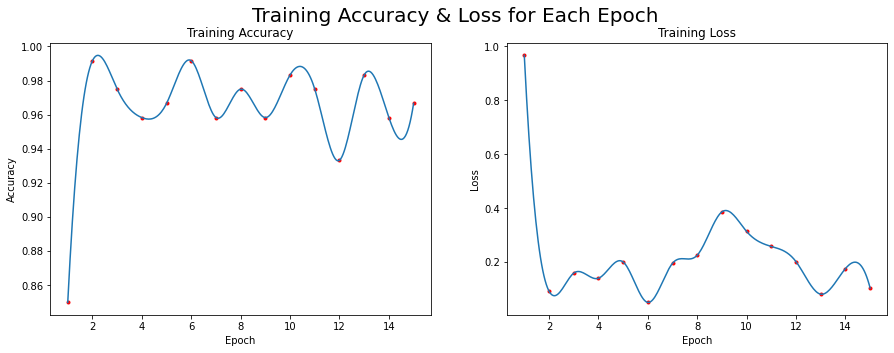

In [38]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1,len(acc)+1)

fig, axs = plt.subplots(1, 2, figsize = (15,5))

epochsLine = np.linspace(1, 15, 300)
gfg = make_interp_spline(epochs, acc, k=3)
accuracyLine = gfg(epochsLine)

axs[0].plot(epochs, acc,'r.', )
axs[0].plot(epochsLine, accuracyLine)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")

epochsLine = np.linspace(1, 15, 300)
gfg = make_interp_spline(epochs, loss, k=3)
lossLine = gfg(epochsLine)

axs[1].plot(epochs,loss,'r.')
axs[1].plot(epochsLine, lossLine)
axs[1].set_title("Training Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

fig.suptitle("Training Accuracy & Loss for Each Epoch", fontsize = 20)
plt.show()

In [ ]:
df = pd.DataFrame(acc) 
    
# saving the dataframe 
df.to_csv('acc.csv') 
df = pd.DataFrame(loss) 
    
# saving the dataframe 
df.to_csv('loss.csv') 

# Testing:

In [56]:
waldoImages = []
def ComputeSquare(val, total, page):
    global waldoImages
    print("Page %s:" %(page))
    ActuallyNotWaldo, ActuallyWaldo = 0, 0
    MistakenWaldo, MistakenNotWaldo = 0, 0

    counter = 0
    decimalpercent = math.ceil(total / 10)
    
    #Waldo
    file_path = os.path.join(val, 'Waldo')
    for f in os.listdir(file_path):
      x = cv2.imread(os.path.join(file_path, f))
      x = np.expand_dims(x, axis=0)
      preds = model.predict(x, verbose = 0)
      if preds[0][1] == 0:
        waldoImages.append(cv2.imread(os.path.join(file_path, f)))
        #plt.imshow(cv2.imread(os.path.join(file_path, f)))
        #plt.show()
        ActuallyWaldo += 1
        counter += 1
      else:
        MistakenNotWaldo += 1
        counter += 1
      if counter % decimalpercent == 0:
        print(counter / decimalpercent * 10, "% completed with page")

    #Color (Not Waldo)
    file_path = os.path.join(val, 'Color')
    for f in os.listdir(file_path):
      x=cv2.imread(os.path.join(file_path, f))
      x = np.expand_dims(x, axis=0)
      preds = model.predict(x, verbose = 0)
      if preds[0][0] == 0:
        MistakenWaldo += 1
        counter += 1
      else:
        ActuallyNotWaldo += 1
        counter += 1
      if counter % decimalpercent == 0:
        print(counter / decimalpercent * 10, "% completed with page")
    return np.array([[ActuallyWaldo, MistakenWaldo], [MistakenNotWaldo, ActuallyNotWaldo]])

In [57]:
result_list = []
for i in range(1, 3):
    pgPath = os.path.join(WORKING_DIR,
                          'Page' + str(i))
    W = os.listdir(os.path.join(pgPath, 'Waldo'))
    NW = os.listdir(os.path.join(pgPath, 'Color'))
    total = len(fnmatch.filter(W,  '*.jpg')) + len(fnmatch.filter(NW,  '*.jpg')) 
    
    results  = ComputeSquare(pgPath, total, i)
    result_list.append(results)
    print(results)

Page 1:
10.0 % completed with page
20.0 % completed with page
30.0 % completed with page
40.0 % completed with page
50.0 % completed with page
60.0 % completed with page
70.0 % completed with page
80.0 % completed with page
90.0 % completed with page
[[   2    0]
 [   3 1333]]
Page 2:
10.0 % completed with page
20.0 % completed with page
30.0 % completed with page
40.0 % completed with page
50.0 % completed with page
60.0 % completed with page
70.0 % completed with page
80.0 % completed with page
90.0 % completed with page
[[  4   0]
 [  1 279]]


In [ ]:
fig, 

In [59]:
len(waldoImages)

6

Text(0.5, 1.0, 'Confusion Matrix')

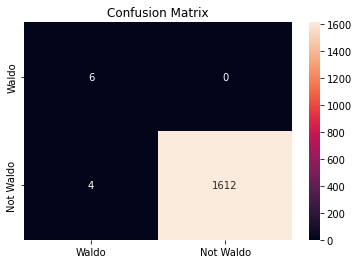

In [60]:
result_sum = np.array([[0,0],[0,0]])
for result in result_list:
  result_sum += result
result_sum = pd.DataFrame(result_sum, index = ["Waldo","Not Waldo"],columns = ["Waldo","Not Waldo"])
ax = sn.heatmap(result_sum, annot=True,  fmt='g', )
plt.title("Confusion Matrix")

In [55]:
waldoImages[0]

array([[[218, 218, 218],
        [ 45,  45,  45],
        [ 44,  44,  44],
        ...,
        [ 55,  55,  55],
        [110, 110, 110],
        [110, 110, 110]],

       [[235, 235, 235],
        [225, 225, 225],
        [ 50,  50,  50],
        ...,
        [ 77,  77,  77],
        [123, 123, 123],
        [108, 108, 108]],

       [[200, 200, 200],
        [233, 233, 233],
        [195, 195, 195],
        ...,
        [132, 132, 132],
        [114, 114, 114],
        [ 98,  98,  98]],

       ...,

       [[249, 249, 249],
        [232, 232, 232],
        [251, 251, 251],
        ...,
        [ 54,  54,  54],
        [127, 127, 127],
        [125, 125, 125]],

       [[246, 246, 246],
        [250, 250, 250],
        [183, 183, 183],
        ...,
        [ 25,  25,  25],
        [119, 119, 119],
        [119, 119, 119]],

       [[251, 251, 251],
        [234, 234, 234],
        [ 87,  87,  87],
        ...,
        [ 28,  28,  28],
        [118, 118, 118],
        [117, 117, 117]]

In [ ]:
model.save(MODEL_FILE)

INFO:tensorflow:Assets written to: /Users/michael/Downloads/CreatedDataset/model/assets


INFO:tensorflow:Assets written to: /Users/michael/Downloads/CreatedDataset/model/assets
